In [12]:
import sys
sys.path.insert(0, '/home/mstorresh/Chalmers/Q_optic/4hands/qgrad/qgrad')

import numpy as np
import matplotlib.pyplot as plt 
from qutip import *
import jax
import jax.numpy as jnp
from jax import grad
from jax import jit
from jax.example_libraries import optimizers
import qgrad_qutip as qg
from jax.config import config
config.update("jax_enable_x64", True)


In [13]:
N:int = 50  # N-> number of levels in Hilbert space 

First I am going to define everything with qutip

For my SNAP I am using a reduce expression that works great for the case from the vaccum to the fock state 1 (it is not the complete definition of SNAP, because the total snap have the form of: $S(\vec{\theta_i}) = \prod_{j=0}^m e^{i \theta_{i,j} |j><j|>}$)

$\hat{U}_{SNAP} (n,\theta) = (e^{i \theta} - 1)|n><n|> $  -> This one is the expression that I will define

In [14]:
Ide = qeye(N)     #Identity matrix
vac = basis(N, 0) # vacuum state
fo_5 = basis(N,5)  #just a fock state to play and try  |5>
alpha = 3  # alpha value for the displacement
the = jnp.pi  # angle for the SNAP operator
Dis = displace(N, alpha)  #Displacement operator from qutip library
nn = lambda foc_s: foc_s * foc_s.dag()  #function to do the outer product
def snap(foc, theta):                   
    """
        Generate the SNAP operator given in the pdf of the hands_in 4. 
    """ 
    return (np.exp(theta*1.j) - 1)*nn(foc) + Ide
result = snap(Qobj(fo_5),the)

In [15]:
f_1 = basis(N,1)
def infidelity(alph1, alph2, thet1): 
    """
        Generate the infifelity of the target state with the final state.
        Args.
            N(int) =  Hilbert space dimension
            alp1, alp2 (float) = angles for the displacement function
            thet1 (float) = angle for the snap operator
        
    """
    fin1 = displace(N,alph2)*snap(vac, thet1)*displace(N,alph1)*vac
    return 1 - fidelity(f_1, fin1)

Now, there is a problem with the compatibility of some packages (jax and qutip). So, the idea is to use another package to solve this, for that I need to re define some functions and Qobjects with the new package (qgrad). This package is similar and based on qutip

In [16]:
# ------------------------------------------------------------------------------------------
# --------------------   Re-definition with qgrad ------------------------------------------
# ------------------------------------------------------------------------------------------
vac0 = qg.basis(N,0)   # |0>               
f01 = qg.basis(N,1)    # |1>
f_1 = basis(N,1)       # |1> qutip
nn1 = lambda foc_s1: jnp.dot(foc_s1,qg.dag(foc_s1))  #function to do the outer product
ide = lambda x: sum(qg.to_dm(qg.basis(x,i)) for i in range(x)) #Identity operator 
dis1 = qg.Displace(N)     # displacement operator
def snap2(foc, theta):    #function to have our SNAP operator, similar that before but with qgrad
    return (jnp.exp(theta*1.j) - 1)*nn1(foc) + ide(N)
snap1 = jit(snap2)        #jit is to make faster the function, it is part of jax library
def infi2(alp1, alp2, thet):
    """
        Generate the infidelity of the target state with the final state.
        Args.
            N(int) =  Hilbert space dimension
            alp1, alp2 (float) = angles for the displacement function
            thet1 (float) = angle for the snap operator      
    """
    fi1 = jnp.dot(dis1(alp1),vac0)            #D(alp1)|0>
    fi1 = jnp.dot(snap1(vac0,thet),fi1)       #Snap(0,thet)*D(alp1) |0>
    fi1 = jnp.dot(dis1(alp2),fi1)             #D(alp2)*Snap(0,thet)*D(alp1) |0> 
    return 1-qg.fidelity(f01,fi1)[0][0] #there is a limitation with the package
infi1 = jit(infi2)

grad_f = jax.grad(infi1, argnums=(0,1,2)) #Obtaining the gradient of the infidelity
print(grad_f)

<function infi2 at 0x7f70a9de44c0>


GD with ADAM optimization for the infidelity

In [17]:
# Initialize parameters
x = 2.   #alpha1
y = -2.0  #alpha2
z = 2.2   #theta

# Define the Adam
opt_init, opt_update, get_params = optimizers.adam(step_size=0.1)

# Initialize the optimizer state
opt_state = opt_init((x, y, z))

# Gradient function of the infidelity, in all variables
grad_fun = jax.grad(infi1, argnums=(0, 1, 2))

# Define a step function to perform one optimization step
def step(i, opt_state):
    params = get_params(opt_state)
    grads = grad_fun(*params)   #unpacks the elements of param
    return opt_update(i, grads, opt_state)

iteration = 0
iteration_list = []
infidelity_list = []

while True:  # Adjust the number of iterations as needed
    opt_state = step(iteration, opt_state)
    params = get_params(opt_state)
    x_o,y_o,z_o = x,y,z
    x, y, z = params
    
    if jnp.abs(infi1(x,y,z) - infi1(x_o,y_o,z_o) )<1e-9: #Threshold to stop the loop
        print(f"Iteration {iteration}: x = {x}, y = {y}, z = {z}, f(x, y, z) = {infi1(x, y, z)}")
        break
    
    # Print progress
    if iteration % 10 == 0:
        print(f"Iteration {iteration}: x = {x}, y = {y}, z = {z}, f(x, y, z) = {infi1(x, y, z)}")

    iteration_list.append(iteration)
    infidelity_list.append(infi1(x,y,z))
    iteration += 1
    

x = float(x)
z = float(z)
y = float(y)
#y_i = jnp.imag(y)

Iteration 0: x = 2.099999989932083, y = -1.9000000077419248, z = 2.2999995391221946, f(x, y, z) = 0.9351036883051947
Iteration 10: x = 2.553793799115473, y = -1.2714704431272106, z = 3.182181875056649, f(x, y, z) = 0.6315631832386482
Iteration 20: x = 2.0277556914755865, y = -1.2632135279745556, z = 3.2191031595094097, f(x, y, z) = 0.4870830202890451
Iteration 30: x = 1.4901655089395045, y = -0.6677077203942612, z = 3.175387173610783, f(x, y, z) = 0.11937322863364311
Iteration 40: x = 0.8714581121908402, y = -0.5211855395294159, z = 3.1477380900236565, f(x, y, z) = 0.09386753835202222
Iteration 50: x = 1.237155829862008, y = -0.5986470000209752, z = 3.1395785321531284, f(x, y, z) = 0.027071333245649642
Iteration 60: x = 1.1829053096360966, y = -0.5941643324268633, z = 3.1354124767051097, f(x, y, z) = 0.020183465974938718
Iteration 70: x = 1.087810990189277, y = -0.5715091206903709, z = 3.139085592834349, f(x, y, z) = 0.02164545663100268
Iteration 80: x = 1.1771134273005048, y = -0.5927

In [18]:
print("Optimal value for alpha_1 =",x)
print("Optimal value for alpha_2 =",y)
print("Optimal value for theta =",z)

Optimal value for alpha_1 = 1.1429380479290503
Optimal value for alpha_2 = -0.5802453968585546
Optimal value for theta = 3.141569339548628


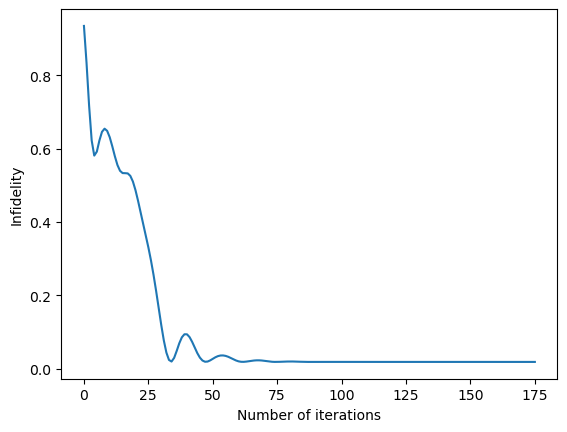

In [19]:
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.plot(iteration_list,infidelity_list)
plt.show()

In [20]:
print(infidelity(x,y,z))
qutip_fi = 1 - float(infidelity(x,y,z))
print(1 - float(infidelity(x,y,z)))
print(infi1(x,y,z))
qgrad_fi = 1 - float(infi1(x,y,z))
print(1 - float(infi1(x,y,z)))
diff = np.abs(qutip_fi - qgrad_fi)/qutip_fi
print("% of difference between the values of fidelity of the 2 librarie: ",diff*100)


0.009341850644577931
0.9906581493554221
0.018596430978286036
0.981403569021714
% of difference between the values of fidelity of the 2 librarie:  0.934185050587796


After obtaining the values with ADAM GD, I can plot with qutip step by step the Wigner function of my states.

- $D(\alpha_1)|0>$
- $\hat{U}_{SNAP} \otimes D(\alpha_1)|0>$
- $D(\alpha_2) \otimes \hat{U}_{SNAP} \otimes D(\alpha_1)|0>$

For this I use again qutip, but with qgrad the plots are very similar. 



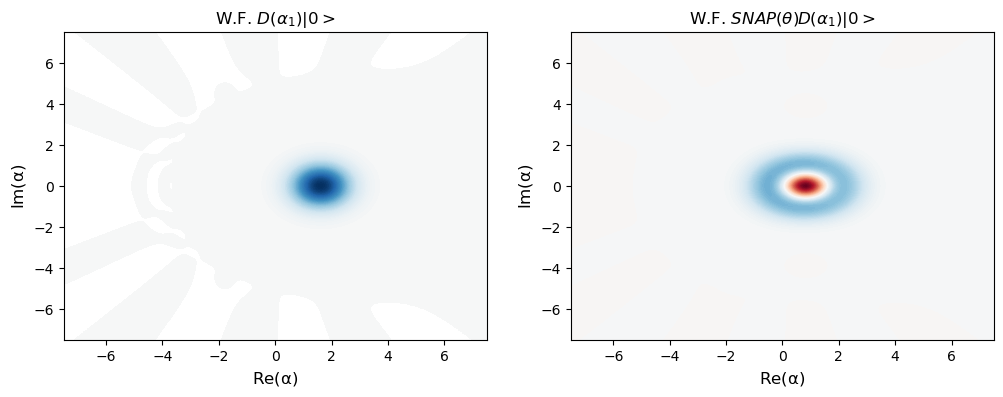

In [21]:
al1, al2 = 2j, 3  
t1 = np.pi  
fin = displace(N,al2)*snap(vac, t1)*displace(N,al1)*vac  # D*SNAP*D|0>

st1 = displace(N,x)*vac   
st2 = snap(vac, z)*st1
st3 = displace(N,y)*st2
fin = displace(N,al2)*snap(fo_5, t1)*displace(N,al1)*vac  #final state
#f_1
fig2,ax2 = plt.subplots(1,2, figsize=(12,4))
plot_wigner(st1, fig=fig2, ax=ax2[0])
ax2[0].set_title(r"W.F. $D(\alpha_1) |0>$")
plot_wigner(st2, fig=fig2, ax=ax2[1])
ax2[1].set_title(r"W.F. $SNAP(\theta) D(\alpha_1) |0>$")
plt.show()

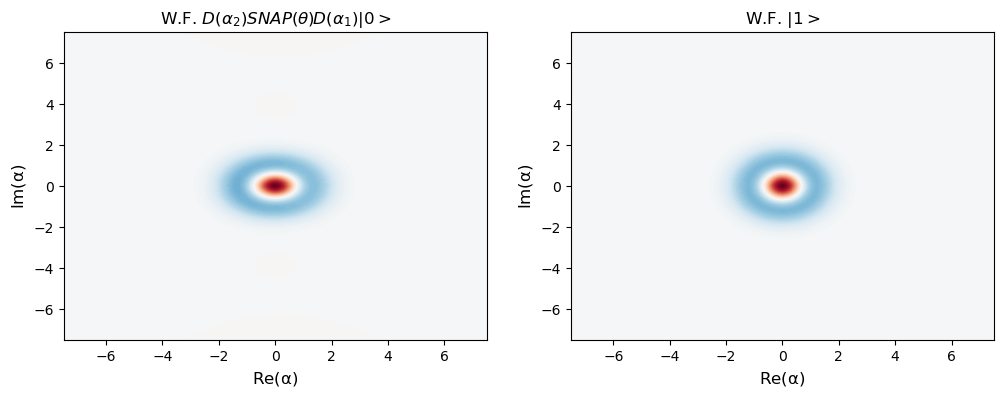

In [22]:
fig3,ax3 = plt.subplots(1,2, figsize=(12,4))
plot_wigner(st3, fig=fig3, ax=ax3[0])
ax3[0].set_title(r"W.F. $D(\alpha_2)SNAP(\theta) D(\alpha_1) |0>$")
plot_wigner(f_1, fig=fig3, ax=ax3[1])
ax3[1].set_title(r"W.F. $|1>$")
plt.show()